In [1]:

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
sys.path.insert(0, os.path.abspath('ComParE2022_VecNet/src'))

import config ,config_pytorch
#from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
# import IPython.display as ipd

# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.models import model_parameters
from glob import glob
## nnAudio
from nnAudio import features , Spectrogram
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import argparse
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'

from timm.models.layers import to_2tuple,trunc_normal_


/opt/conda/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [2]:
# Parse input arguments
#parser = argparse.ArgumentParser(description='Trainable_SpecAugment', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
batch_size =128
num_workers=4
pin_memory = True
test_batch_size=128
DEBUG= False
num_epochs =200
USE_SHORT_AUDIO = True,
                



In [3]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]

In [4]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    #This is same as defined in config -min_duration = win_size * frame_duration
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    stride = step_frac*min_length
#     print("min_length = " +str(min_length))
#     print("step_frac = " +str(step_frac))
#     print("stride = " +str(stride))
    for _,row in df.iterrows():
        #processed_data keeps track of the tensor_values processed thus far
        if row['length'] > min_length:
            processed_data = 0
            #total_data is the total tensor present in the audio
            total_data = config.rate*row['length']
            #print("********")
            count = 0
            #print("count = " +str(count))
            #print("id = " + str(row['id']) + " duration = " +str(row['length']) + "total x vals = " + str(total_data))
            inner_loop_flag = False
            #print("going into the inner loop to offset....")
            while(processed_data < total_data):
                #print("inside inner loop.....")
                start = count*stride*config.rate
                #now find out the row_len
                if total_data - (start + min_length*config.rate) >= 0:
                    #print("full chunk ")
                    row_len = min_length
                    end = start + row_len*config.rate
                    audio_offsets.append({'id':row['id'], 'offset':count, 'length': row_len,'specie_ind': row['specie_ind'],'start':start,'end':end})
                    #print("count = " +str(count) + "offset = " +str(count) + "start = " +str(start) + "end = " +str(end))
                    #print("for count.... = " + str(count) + "processed data = " +str(processed_data))
                    count+=1
                    processed_data = (count*stride)*config.rate
                    
                else:
                    inner_loop_flag = True
                    break
                    
                                                       
            #for processing residual data
            if(inner_loop_flag):
                #print("processing residual ....processed " +str(processed_data) + " of " + str(total_data))
                start = count*stride*config.rate
                resid_durn = round((total_data - processed_data)/config.rate,2)
                end = total_data
                #print("for..." + str(row['id']) + " adding the residual data in the data frame with duration = " + str(resid_durn))
                audio_offsets.append({'id':row['id'], 'offset':count, 'length':resid_durn ,'specie_ind': row['specie_ind'],'start':start,'end':end})
            
        elif short_audio:
            start = 0
            end = row['length']*config.rate
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind'],'start':0 , 'end':end})
    return pd.DataFrame(audio_offsets)       


In [5]:

def prepare_df(classes ,csv_loc = config.data_df  ):
    """This function reads a csv and creates a dataframe for further processing."""
    df = pd.read_csv(csv_loc)
    #df = df.loc[df['Grade'].notnull()]
    df = df.loc[df['species'].notnull()]
    # a new column for specie_index to hold numerical values for specie
    df['specie_ind'] = "NULL_VAL"
    ind = 0
    for specie in classes:
        print("specie = " + str(specie) + "and its index = " + str(ind) )
        row_indexes=df[df['species']==specie].index 
        df.loc[row_indexes,'specie_ind']= ind
        ind+=1
    #remove all the rows where specie is other than the one present in classes
    df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
    #filter the data for TZ and cup recordings only
    idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
    df_all = df[idx_multiclass]
    df_all.reset_index(inplace=True, drop = True )
    return df_all


In [6]:
def plot_df(df):
    fig, ax = plt.subplots(figsize=(8, 6))
    import seaborn as sns
    sns.countplot(x = 'species', data = df , ax = ax , hue = 'gender',palette='dark')
    #ax.bar_label(ax.containers[0])
    #ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
    plt.xticks(rotation=90 )
    plt.title("Distribution of Species ")
    plt.rc('xtick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('axes', labelsize=15)
    plt.rc('figure', titlesize=15)
    plt.show

### Train _test split####
def train_test_split(df_all):
    np.random.seed(42)
    msk_test = np.random.rand(len(df_all)) < 0.2
    df_test = df_all[msk_test]
    df_train_temp  = df_all[~msk_test]
    msk_train = np.random.rand(len(df_train_temp)) < 0.2
    df_val = df_train_temp[msk_train]
    df_train  = df_train_temp[~msk_train]
    return df_train ,df_val ,df_test

### Validate split ####
def validate_split(df1 , df2):
    df_temp = pd.merge(df1,df2, on = 'id', how = 'inner')
    #print(df_temp)
    common_elem = len(df_temp)
    #print("common_elem = ",common_elem)
    con = (common_elem == 0)
    #print("condition = ",con)
    assert (con), "Split has issues"
    print("split is a success")

### Specie _distribution ###
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))

## Class weights to address imbalance in classes ###
def get_class_weights(df):
    np.array(df_train_offset.specie_ind)
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df.specie_ind)),y=np.array(np.array(df.specie_ind)))
    print(type(class_weights))
    print(class_weights.shape)
    return class_weights


In [7]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=8, fstride=10, tstride=10, input_fdim=1025, input_tdim=31, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            #print("original_num_patches = ",self.original_num_patches)
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            #print("oringal_hw = ",self.oringal_hw)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            #print("original_embedding_dim = ",self.original_embedding_dim)
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [8]:
torch.tensor(2.6860e-05)
torch.tensor(0.0094)

tensor(0.0094)

In [9]:
class MyModel(nn.Module):
    def __init__(self, mean = torch.tensor(2.6860e-05), std = torch.tensor(0.0094)):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = ASTModel()
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        #self.out = nn.Linear(self.backbone.num_features, 1)
        self.mean = mean
        self.std = std
        #self.sizer = VT.Resize((image_size,image_size),antialias = True)
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=2*config.rate, output_format="Magnitude", trainable=False,verbose = False).to('cuda')
        self.batch_norm = nn.BatchNorm2d(num_features= 1)
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x,train = True):
        # first compute spectrogram
        spec_gram = self.spec_layer(x)
        #print("post spec gram shape = ",spec_gram.shape)
        #print("post norm shape = ",spec_gram.shape)
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after spec gram creation."
        
        with torch.no_grad():
            if train == True:
                #generate a random number and if condition is met apply aug
                ta_transformations_rndm_choice = VT.RandomChoice([AT.FrequencyMasking(freq_mask_param=100),AT.TimeMasking(time_mask_param=50)], p=[.4, .4])
                ta_transformations_rndm_apply = VT.RandomApply([AT.FrequencyMasking(freq_mask_param=50),AT.TimeMasking(time_mask_param=25)],p = .15)
                spec_gram = ta_transformations_rndm_choice(spec_gram)
                spec_gram = ta_transformations_rndm_apply(spec_gram)
                spec_gram_nan_check = torch.isnan(spec_gram).any().item()
                assert not (spec_gram_nan_check) ,"Tensor contains NaN values after augmentations  "
                
                
        #print("spec_gram shape = ",spec_gram.shape)    
        
        #x = self.sizer(spec_gram.squeeze(dim = 1))
        #print("post sizer shape = ",x.shape)
        #fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        x = (spec_gram - self.mean) / (self.std * 2)
        #print("post norm = ",x.shape)
        
        # then repeat channels
        del spec_gram,spec_gram_nan_check
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
                
        x = torch.transpose(x, 1, 2)
        x = self.backbone(x)
        backbone_op_nan_check = torch.isnan(x).any().item()
        assert not (backbone_op_nan_check) ,"Tensor contains NaN values in the backbone OP "
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred }
        #print(output)
        del x , backbone_op_nan_check
        return output


In [10]:
####### Prepare df######

#### plt df

### Pad_mean #####
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)


### Plot confusion Matrix ######
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()





    

# ### Model class ####
# Subclass the pretrained model and make it a binary classification
# Subclass the pretrained model and make it a binary classification

# Subclass the pretrained model and make it a binary classification



In [11]:
### Test Model####
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x,train = False)['prediction']
            #y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [12]:

## Train_model ####
#train_loader, val_loader, test_loader,model,classes,df_train_offset ,num_epochs = num_epochs 
def train_model(train_loader, val_loader,test_loader, model ,classes,class_weights,num_epochs ):
    # Creates a GradScaler once at the beginning of training.
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion_1 = nn.CrossEntropyLoss(weight=weights_adj,label_smoothing=.1)
    criterion_2 = nn.CrossEntropyLoss(weight=weights_adj)
    lr = .000015
    base_optimiser = timm.optim.AdamP(model.parameters(), lr= lr)
    look_optimiser = timm.optim.Lookahead(base_optimiser)
    cooldown_epoch = 50
    
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    #timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    scheduler = timm.scheduler.CosineLRScheduler(base_optimiser, t_initial= num_epochs,lr_min= lr/100,warmup_t = 5,warmup_lr_init= lr/10,noise_std=.075)
       
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    accumulation_steps = 4
    lr_log = []
    for e in range(num_epochs + cooldown_epoch):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 100 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
                
            
            y = inputs[1].type(torch.LongTensor).to(device)
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
                                  
            with autocast():
                y_pred = model(x,train = True)['prediction']
                #y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred, axis = 1)
                if e < 20 :
                    
                    loss = criterion_1(y_pred, y)
                else:
                    
                    loss = criterion_2(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                   
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            loss.backward()
            all_y_pred.append(preds.cpu().detach())
            base_optimiser.step()
            base_optimiser.zero_grad()
            #scheduler.step(e)
                
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 1.0 )
            base_optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        look_optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            current_lr = base_optimiser.param_groups[0]['lr']
            print("Current LR = " + '{0:.8f}'.format(current_lr))
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        scheduler.step(e+1)
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1




In [13]:

#### Dataste class #####
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        temp_id = int(self.audio_df.loc[idx]['id'])
        file_path = os.path.join("..","..","data","audio")
        path_var = file_path +"/" +str(temp_id)+ str(".wav")
        entire_aud, inp_rate = torchaudio.load(path_var)
        if inp_rate != 2*config.rate:
            #print(" Original sample rate = " +str(inp_rate)+ " resampling ...")
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, 2*config.rate, dtype=entire_aud.dtype)
            entire_aud = resampler(entire_aud)
            #print("processsing file on " +str(path_var) + "Post resample shape =  " + str(entire_aud.shape))
        
        aud_len = self.audio_df.loc[idx]['length']
        offset = int(self.audio_df.loc[idx]['offset'])
        #print("sliced val = " +str(int((offset+config.min_duration)*config.rate)))
        start_pos = int(round(self.audio_df.loc[idx]['start']))
        #print("start_pos = " +str(start_pos))
        end_pos =  int(round(self.audio_df.loc[idx]['end']))
        #print("end_pos = " +str(end_pos))
        x = entire_aud[:,start_pos:end_pos]
        #print("extracted x = " +str(x))
        #print("x shape = " +str(x.shape))
        if aud_len < config.min_duration:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            #print("padding on " +str(path_var))
            f_out = pad_mean(x)
            #print("returning from padding  SHape = " +str(f_out.shape))
        else:
            f_out = x[0]
            f_out = f_out.unsqueeze(0)
            
        if DEBUG:
            print("idx = " + str(idx))
            #print("offset = " + str(offset))
            #print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(f_out.shape))
        
        #x_val = x[:,start:end]
        #now that we have final x- let's create specgram and add augmentations.
                 
        return (f_out,self.audio_df.loc[idx]['specie_ind'] )

In [14]:
### Get_indices ####
def get_indices(num_values ,df ,classes = classes):
    new_df = pd.DataFrame()
    for ind in range(len(classes)):
        #print("ind = ", ind)
        op = df[df['specie_ind'] == ind]
        #print("len op = ", len(op))
        op_new = op.sample(n = 1)
        #print("rand_ind = " , rand_ind)
        #([df1, df2], axis=1)
        new_df = pd.concat([op_new,new_df],axis = 0)
        #print("elem = " , elem)
        #new_list.append(elem)
    if len(new_df) < num_values:
        diff =  num_values - len(new_df)
        #print("diff = ", diff)
        remaining_elems= df.sample(n = diff)
        #print("len of remaining elems = ", len(remaining_elems))
        new_df = pd.concat([remaining_elems,new_df],axis = 0)
        
    #print("new_df = ", new_df)    
    new_df_1 = new_df.reset_index(drop = True)
    return new_df_1

#### Load model ####


In [15]:
def get_mean(loader):
    # set skip_norm as True only when you are computing the normalization stats
    #audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 24, 'timem': 192, 'mixup': 0.5, 'skip_norm': True, 'mode': 'train', 'dataset': 'audioset'}
    mean=[]
    std=[]
    for i, (audio_input, labels) in enumerate(loader):
        cur_mean = torch.mean(audio_input)
        cur_std = torch.std(audio_input)
        mean.append(cur_mean)
        std.append(cur_std)
        #print(cur_mean, cur_std)
    avg_mean = sum(mean)/len(mean)
    avg_std = sum(std)/len(std)
    #std_tensor = torch.cat(std)
    return avg_mean ,avg_std
#print(np.mean(mean), np.mean(std))

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7
now validating the split post loading and keeping TZ data
split is a success
split is a success
split is a success
now validating the split post offset_creation
split is a success
split is a success
split is a success
<class 'numpy.ndarray'>
(8,)
inside main. class_weigths type =  <class 'numpy.ndarray'>


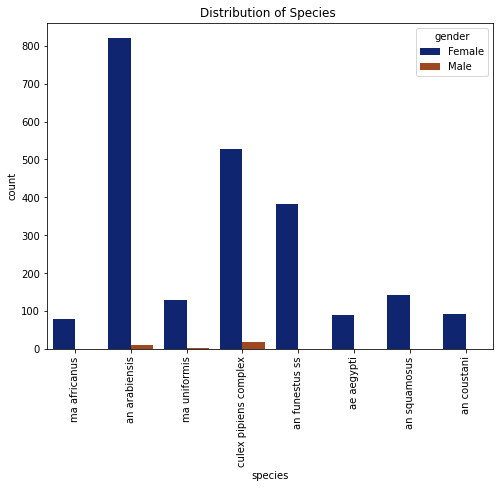

In [16]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
           'an coustani','ma uniformis','ma africanus' ]
csv_loc = os.path.join("..","..","data","metadata","neurips_2021_zenodo_0_0_1.csv")
df = prepare_df(classes = classes,csv_loc = csv_loc)
plot_df(df)
df_train ,df_val ,df_test = train_test_split(df)
print("now validating the split post loading and keeping TZ data")
validate_split(df_train ,df_val)
validate_split(df_train ,df_test)
validate_split(df_test ,df_val)
df_train_offset = get_offsets_df(df_train, short_audio=True)
df_test_offset = get_offsets_df(df_test, short_audio=True)
df_val_offset = get_offsets_df(df_val, short_audio=True)
df_train_offset.reset_index(inplace = True , drop = True)
df_test_offset.reset_index(inplace = True , drop = True)
df_val_offset.reset_index(inplace = True , drop = True)
print("now validating the split post offset_creation")
validate_split(df_train_offset ,df_val_offset)
validate_split(df_train_offset ,df_test_offset)
validate_split(df_test_offset ,df_val_offset)

class_weights = get_class_weights(df_train_offset)
print("inside main. class_weigths type = ", type(class_weights))

    

    


In [17]:
min_length = (config.win_size * config.n_hop) / config.rate

train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory, shuffle = True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,shuffle = True)

In [18]:
#mean,std = get_mean(train_loader)

In [19]:
# print(mean)
# print(std)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=202
Training on cuda:0
epoch = 0batch = 0 of 283duraation = 0.06033658583958944


/opt/conda/lib/python3.8/site-packages/timm/optim/adamp.py:84: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


epoch = 0batch = 100 of 283duraation = 1.5499634265899658
epoch = 0batch = 200 of 283duraation = 3.0438015778859455
Epoch: 0, Train Loss: 2.41413114, Train f1: 0.04374305, Val Loss: 0.02463924, Val f1: 0.04128188, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e0_2023_05_20_23_23_23.pth
Now printing classification rport... 
********************************
Current LR = 0.00000150
                       precision    recall  f1-score   support

        an arabiensis       0.52      0.02      0.03      4717
culex pipiens complex       0.31      0.01      0.02      2105
           ae aegypti       0.12      0.40      0.18       484
       an funestus ss       0.35      0.03      0.05      2114
         an squamosus       0.05      0.03      0.04       559
          an coustani       0.04      0.51      0.08       350
         ma uniformis       0.07      0.31      0.12       491
         ma africanus       0.04      0.51      0.08       223

             accu

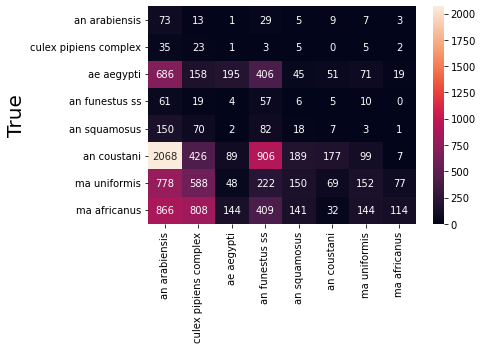

epoch = 1batch = 0 of 283duraation = 0.05385598341623942
epoch = 1batch = 100 of 283duraation = 1.551330324014028
epoch = 1batch = 200 of 283duraation = 3.049147192637126
Epoch: 1, Train Loss: 2.34571568, Train f1: 0.07631480, Val Loss: 0.02371880, Val f1: 0.14998484, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e1_2023_05_20_23_29_51.pth
Now printing classification rport... 
********************************
Current LR = 0.00000420
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.08      0.14      4717
culex pipiens complex       0.50      0.08      0.14      2105
           ae aegypti       0.16      0.74      0.27       484
       an funestus ss       0.49      0.16      0.24      2114
         an squamosus       0.10      0.21      0.14       559
          an coustani       0.06      0.44      0.11       350
         ma uniformis       0.09      0.36      0.14       491
         ma africanus     

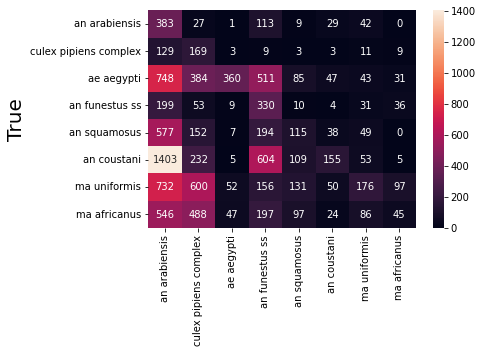

epoch = 2batch = 0 of 283duraation = 0.054311319192250566
epoch = 2batch = 100 of 283duraation = 1.5571706732114157
epoch = 2batch = 200 of 283duraation = 3.0410551905632017
Epoch: 2, Train Loss: 2.25574359, Train f1: 0.13827571, Val Loss: 0.02126039, Val f1: 0.26756152, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e2_2023_05_20_23_36_12.pth
Now printing classification rport... 
********************************
Current LR = 0.00000690
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.21      0.31      4717
culex pipiens complex       0.48      0.15      0.23      2105
           ae aegypti       0.26      0.78      0.39       484
       an funestus ss       0.55      0.24      0.34      2114
         an squamosus       0.22      0.13      0.17       559
          an coustani       0.06      0.62      0.11       350
         ma uniformis       0.12      0.19      0.15       491
         ma africanus  

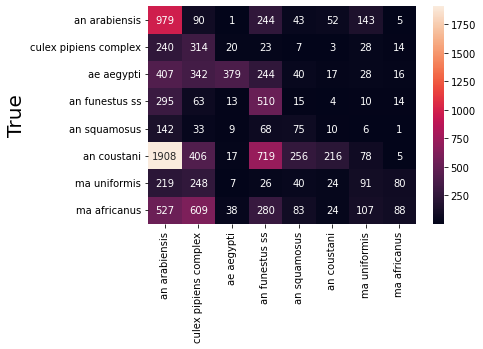

epoch = 3batch = 0 of 283duraation = 0.05286588271458944
epoch = 3batch = 100 of 283duraation = 1.573531941572825
epoch = 3batch = 200 of 283duraation = 3.0577731370925902
Epoch: 3, Train Loss: 2.23758613, Train f1: 0.15668075, Val Loss: 0.02133794, Val f1: 0.26900492, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e3_2023_05_20_23_42_33.pth
Now printing classification rport... 
********************************
Current LR = 0.00000960
                       precision    recall  f1-score   support

        an arabiensis       0.69      0.10      0.18      4717
culex pipiens complex       0.44      0.30      0.36      2105
           ae aegypti       0.30      0.65      0.41       484
       an funestus ss       0.44      0.40      0.42      2114
         an squamosus       0.09      0.31      0.14       559
          an coustani       0.07      0.49      0.12       350
         ma uniformis       0.12      0.34      0.18       491
         ma africanus    

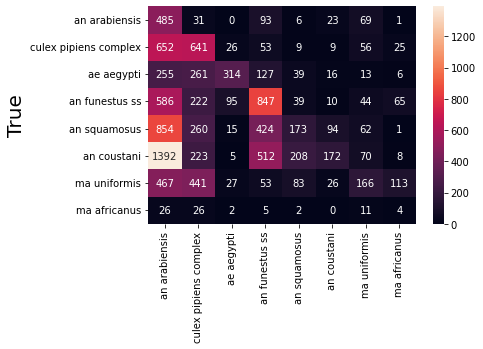

epoch = 4batch = 0 of 283duraation = 0.05129682223002116
epoch = 4batch = 100 of 283duraation = 1.5459925373395285
epoch = 4batch = 200 of 283duraation = 3.0259066025416055
..Overrun....no improvement
Epoch: 4, Train Loss: 2.27402471, Train f1: 0.10898983, Val Loss: 0.02290415, Val f1: 0.18105504, overrun_counter 0
epoch = 5batch = 0 of 283duraation = 0.05595561663309733
epoch = 5batch = 100 of 283duraation = 1.5559495488802593
epoch = 5batch = 200 of 283duraation = 3.053394142786662
..Overrun....no improvement
Epoch: 5, Train Loss: 2.24219537, Train f1: 0.15579597, Val Loss: 0.02224886, Val f1: 0.19436791, overrun_counter 1
epoch = 6batch = 0 of 283duraation = 0.05658415953318278
epoch = 6batch = 100 of 283duraation = 1.5211166262626648
epoch = 6batch = 200 of 283duraation = 3.023897929986318
..Overrun....no improvement
Epoch: 6, Train Loss: 2.17142526, Train f1: 0.19158566, Val Loss: 0.02204154, Val f1: 0.17706339, overrun_counter 2
epoch = 7batch = 0 of 283duraation = 0.053407200177

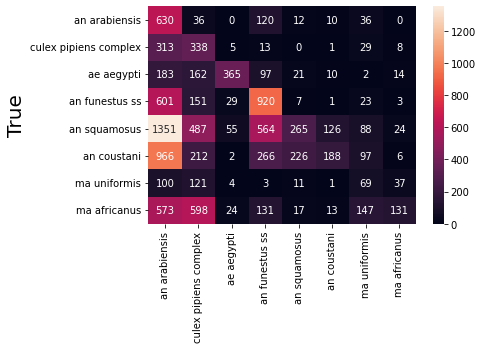

epoch = 8batch = 0 of 283duraation = 0.05290571053822835
epoch = 8batch = 100 of 283duraation = 1.5323890844980876
epoch = 8batch = 200 of 283duraation = 3.0254742463429767
Epoch: 8, Train Loss: 2.09422974, Train f1: 0.26963088, Val Loss: 0.02005627, Val f1: 0.39033255, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e8_2023_05_21_00_10_29.pth
Now printing classification rport... 
********************************
Current LR = 0.00001494
                       precision    recall  f1-score   support

        an arabiensis       0.78      0.28      0.41      4717
culex pipiens complex       0.45      0.34      0.39      2105
           ae aegypti       0.46      0.77      0.58       484
       an funestus ss       0.51      0.69      0.59      2114
         an squamosus       0.16      0.27      0.20       559
          an coustani       0.17      0.51      0.25       350
         ma uniformis       0.17      0.42      0.24       491
         ma africanus   

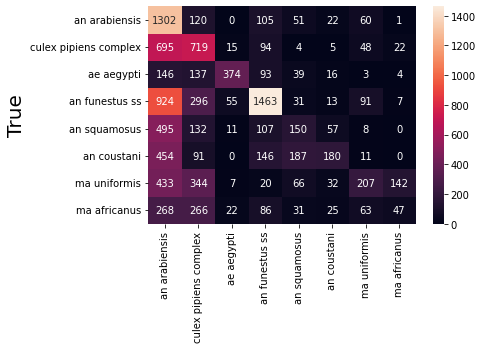

epoch = 9batch = 0 of 283duraation = 0.054979145526885986
epoch = 9batch = 100 of 283duraation = 1.5318692684173585
epoch = 9batch = 200 of 283duraation = 3.0269951661427816
..Overrun....no improvement
Epoch: 9, Train Loss: 2.05081863, Train f1: 0.31378743, Val Loss: 0.02045679, Val f1: 0.37382597, overrun_counter 0
epoch = 10batch = 0 of 283duraation = 0.05668630202611288
epoch = 10batch = 100 of 283duraation = 1.5530258297920227
epoch = 10batch = 200 of 283duraation = 3.0164880633354185
Epoch: 10, Train Loss: 2.00153227, Train f1: 0.34985913, Val Loss: 0.01819532, Val f1: 0.44477323, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e10_2023_05_21_00_21_53.pth
Now printing classification rport... 
********************************
Current LR = 0.00001491
                       precision    recall  f1-score   support

        an arabiensis       0.84      0.29      0.43      4717
culex pipiens complex       0.48      0.57      0.52      2105
           ae ae

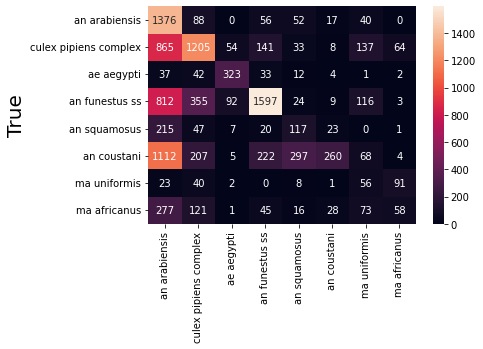

epoch = 11batch = 0 of 283duraation = 0.05839800834655762
epoch = 11batch = 100 of 283duraation = 1.55509748061498
epoch = 11batch = 200 of 283duraation = 3.0393081943194074
Epoch: 11, Train Loss: 1.95346561, Train f1: 0.38462094, Val Loss: 0.01896388, Val f1: 0.47252805, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e11_2023_05_21_00_28_13.pth
Now printing classification rport... 
********************************
Current LR = 0.00001489
                       precision    recall  f1-score   support

        an arabiensis       0.81      0.37      0.51      4717
culex pipiens complex       0.58      0.38      0.46      2105
           ae aegypti       0.61      0.74      0.67       484
       an funestus ss       0.54      0.69      0.61      2114
         an squamosus       0.15      0.43      0.22       559
          an coustani       0.15      0.70      0.24       350
         ma uniformis       0.30      0.27      0.28       491
         ma africanus

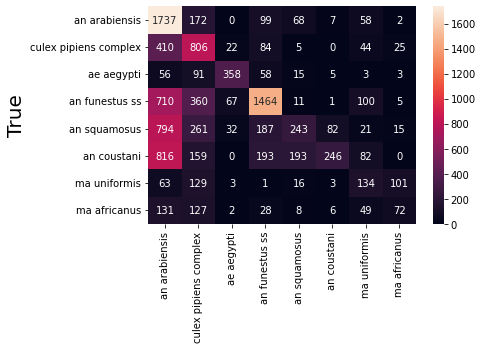

epoch = 12batch = 0 of 283duraation = 0.05816108783086141
epoch = 12batch = 100 of 283duraation = 1.5591841220855713
epoch = 12batch = 200 of 283duraation = 3.054660709698995
..Overrun....no improvement
Epoch: 12, Train Loss: 1.90686927, Train f1: 0.41325570, Val Loss: 0.01990677, Val f1: 0.45442957, overrun_counter 0
epoch = 13batch = 0 of 283duraation = 0.058638930320739746
epoch = 13batch = 100 of 283duraation = 1.52364395459493
epoch = 13batch = 200 of 283duraation = 3.0342742522557575
Epoch: 13, Train Loss: 1.84051346, Train f1: 0.44153107, Val Loss: 0.01669748, Val f1: 0.55253848, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e13_2023_05_21_00_39_38.pth
Now printing classification rport... 
********************************
Current LR = 0.00001485
                       precision    recall  f1-score   support

        an arabiensis       0.79      0.57      0.66      4717
culex pipiens complex       0.52      0.52      0.52      2105
           ae a

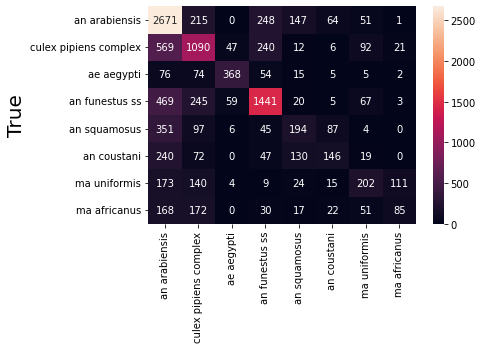

epoch = 14batch = 0 of 283duraation = 0.05564514398574829
epoch = 14batch = 100 of 283duraation = 1.5434146682421366
epoch = 14batch = 200 of 283duraation = 3.0618212183316547
..Overrun....no improvement
Epoch: 14, Train Loss: 1.78773521, Train f1: 0.48656483, Val Loss: 0.01790195, Val f1: 0.53052467, overrun_counter 0
epoch = 15batch = 0 of 283duraation = 0.05479892492294312
epoch = 15batch = 100 of 283duraation = 1.5503501057624818
epoch = 15batch = 200 of 283duraation = 3.034377133846283
..Overrun....no improvement
Epoch: 15, Train Loss: 1.75932538, Train f1: 0.50184968, Val Loss: 0.01720839, Val f1: 0.54977261, overrun_counter 1
epoch = 16batch = 0 of 283duraation = 0.05310739676157634
epoch = 16batch = 100 of 283duraation = 1.5322580377260844
epoch = 16batch = 200 of 283duraation = 3.0423617601394652
Epoch: 16, Train Loss: 1.70175938, Train f1: 0.54125189, Val Loss: 0.01683456, Val f1: 0.57684897, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e16_20

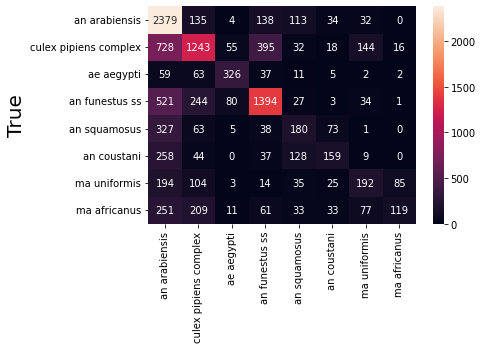

epoch = 17batch = 0 of 283duraation = 0.05867912371953329
epoch = 17batch = 100 of 283duraation = 1.564024563630422
epoch = 17batch = 200 of 283duraation = 3.043985144297282
Epoch: 17, Train Loss: 1.73511979, Train f1: 0.53051140, Val Loss: 0.01650411, Val f1: 0.58767699, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e17_2023_05_21_01_02_32.pth
Now printing classification rport... 
********************************
Current LR = 0.00001474
                       precision    recall  f1-score   support

        an arabiensis       0.80      0.59      0.68      4717
culex pipiens complex       0.59      0.52      0.55      2105
           ae aegypti       0.75      0.64      0.69       484
       an funestus ss       0.64      0.69      0.66      2114
         an squamosus       0.22      0.39      0.28       559
          an coustani       0.22      0.55      0.32       350
         ma uniformis       0.31      0.41      0.35       491
         ma africanus

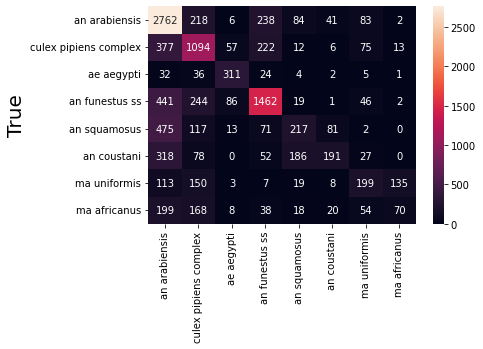

epoch = 18batch = 0 of 283duraation = 0.05361299514770508
epoch = 18batch = 100 of 283duraation = 1.5411103248596192
epoch = 18batch = 200 of 283duraation = 3.0372596343358356
Epoch: 18, Train Loss: 1.69844643, Train f1: 0.54894274, Val Loss: 0.01584950, Val f1: 0.59299358, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e18_2023_05_21_01_08_54.pth
Now printing classification rport... 
********************************
Current LR = 0.00001471
                       precision    recall  f1-score   support

        an arabiensis       0.85      0.52      0.65      4717
culex pipiens complex       0.44      0.69      0.54      2105
           ae aegypti       0.74      0.69      0.71       484
       an funestus ss       0.64      0.67      0.65      2114
         an squamosus       0.29      0.33      0.31       559
          an coustani       0.24      0.45      0.31       350
         ma uniformis       0.32      0.38      0.34       491
         ma african

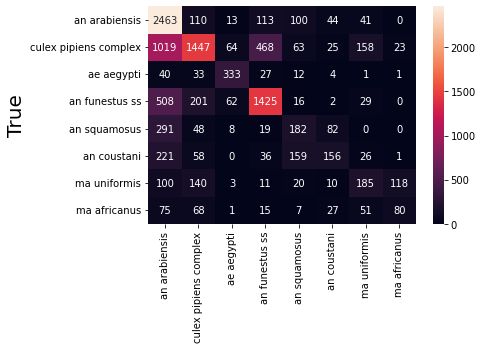

epoch = 19batch = 0 of 283duraation = 0.055726857980092366
epoch = 19batch = 100 of 283duraation = 1.5629867752393087
epoch = 19batch = 200 of 283duraation = 3.0627375205357867
..Overrun....no improvement
Epoch: 19, Train Loss: 1.64700999, Train f1: 0.57635194, Val Loss: 0.01681177, Val f1: 0.58076181, overrun_counter 0
epoch = 20batch = 0 of 283duraation = 0.0509133259455363
epoch = 20batch = 100 of 283duraation = 1.5662791768709818
epoch = 20batch = 200 of 283duraation = 3.0550874908765158
..Overrun....no improvement
Epoch: 20, Train Loss: 0.98985421, Train f1: 0.58393029, Val Loss: 0.01592671, Val f1: 0.55623087, overrun_counter 1
epoch = 21batch = 0 of 283duraation = 0.05753672917683919
epoch = 21batch = 100 of 283duraation = 1.5503623843193055
epoch = 21batch = 200 of 283duraation = 3.0453476985295613
Epoch: 21, Train Loss: 0.94915388, Train f1: 0.59796227, Val Loss: 0.01359985, Val f1: 0.60402246, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e21_2

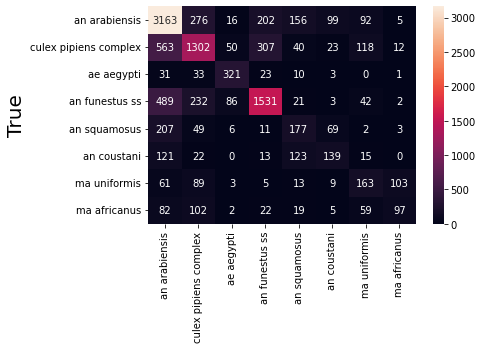

epoch = 22batch = 0 of 283duraation = 0.056298041343688966
epoch = 22batch = 100 of 283duraation = 1.5463255246480305
epoch = 22batch = 200 of 283duraation = 3.0333353956540425
Epoch: 22, Train Loss: 0.92350828, Train f1: 0.60118240, Val Loss: 0.01389212, Val f1: 0.62299167, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e22_2023_05_21_01_31_49.pth
Now printing classification rport... 
********************************
Current LR = 0.00001456
                       precision    recall  f1-score   support

        an arabiensis       0.76      0.72      0.74      4717
culex pipiens complex       0.50      0.63      0.56      2105
           ae aegypti       0.59      0.81      0.68       484
       an funestus ss       0.74      0.54      0.62      2114
         an squamosus       0.32      0.34      0.33       559
          an coustani       0.28      0.44      0.34       350
         ma uniformis       0.35      0.33      0.34       491
         ma africa

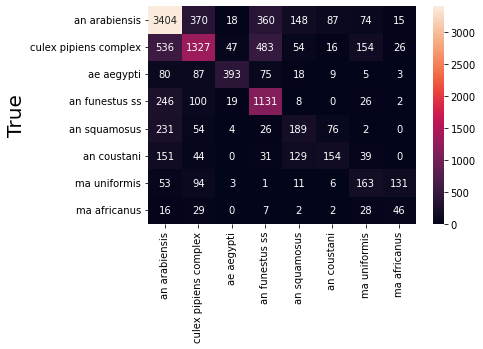

epoch = 23batch = 0 of 283duraation = 0.0595306674639384
epoch = 23batch = 100 of 283duraation = 1.5569472273190816
epoch = 23batch = 200 of 283duraation = 3.054250148932139
..Overrun....no improvement
Epoch: 23, Train Loss: 0.87843264, Train f1: 0.62092069, Val Loss: 0.01361686, Val f1: 0.61549993, overrun_counter 0
epoch = 24batch = 0 of 283duraation = 0.06158996025721232
epoch = 24batch = 100 of 283duraation = 1.5552712599436442
epoch = 24batch = 200 of 283duraation = 3.0502758463223776
..Overrun....no improvement
Epoch: 24, Train Loss: 0.82263370, Train f1: 0.64291323, Val Loss: 0.01431322, Val f1: 0.62097344, overrun_counter 1
epoch = 25batch = 0 of 283duraation = 0.05535192092259725
epoch = 25batch = 100 of 283duraation = 1.5614142139752707
epoch = 25batch = 200 of 283duraation = 3.0468512614568075
..Overrun....no improvement
Epoch: 25, Train Loss: 0.79272381, Train f1: 0.65715570, Val Loss: 0.01546819, Val f1: 0.59325777, overrun_counter 2
epoch = 26batch = 0 of 283duraation = 0

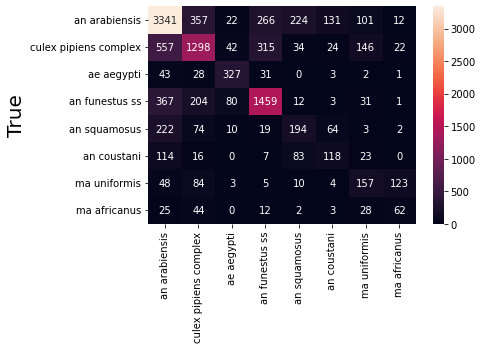

epoch = 27batch = 0 of 283duraation = 0.05395222504933675
epoch = 27batch = 100 of 283duraation = 1.5420730272928873
epoch = 27batch = 200 of 283duraation = 3.0359472235043845
..Overrun....no improvement
Epoch: 27, Train Loss: 0.85908876, Train f1: 0.63561210, Val Loss: 0.01617213, Val f1: 0.60368564, overrun_counter 0
epoch = 28batch = 0 of 283duraation = 0.055499072869618735
epoch = 28batch = 100 of 283duraation = 1.5467844525973002
epoch = 28batch = 200 of 283duraation = 3.0267345945040387
..Overrun....no improvement
Epoch: 28, Train Loss: 0.79942560, Train f1: 0.65517645, Val Loss: 0.01540884, Val f1: 0.61888085, overrun_counter 1
epoch = 29batch = 0 of 283duraation = 0.056961647669474286
epoch = 29batch = 100 of 283duraation = 1.546794315179189
epoch = 29batch = 200 of 283duraation = 3.030712640285492
..Overrun....no improvement
Epoch: 29, Train Loss: 0.73994961, Train f1: 0.68501062, Val Loss: 0.01544634, Val f1: 0.61881542, overrun_counter 2
epoch = 30batch = 0 of 283duraation =

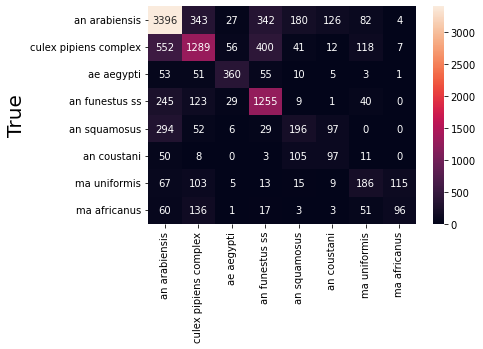

epoch = 31batch = 0 of 283duraation = 0.05709009965260824
epoch = 31batch = 100 of 283duraation = 1.5665235797564188
epoch = 31batch = 200 of 283duraation = 3.0966549436251323
..Overrun....no improvement
Epoch: 31, Train Loss: 0.79960316, Train f1: 0.66544428, Val Loss: 0.01660973, Val f1: 0.62053877, overrun_counter 0
epoch = 32batch = 0 of 283duraation = 0.05401225487391154
epoch = 32batch = 100 of 283duraation = 1.5283788363138835
epoch = 32batch = 200 of 283duraation = 3.0330935875574747
..Overrun....no improvement
Epoch: 32, Train Loss: 0.76261462, Train f1: 0.68098248, Val Loss: 0.01657282, Val f1: 0.61734002, overrun_counter 1
epoch = 33batch = 0 of 283duraation = 0.05778312683105469
epoch = 33batch = 100 of 283duraation = 1.532653820514679
epoch = 33batch = 200 of 283duraation = 3.028281271457672
..Overrun....no improvement
Epoch: 33, Train Loss: 0.77625795, Train f1: 0.67273499, Val Loss: 0.01687130, Val f1: 0.60806960, overrun_counter 2
epoch = 34batch = 0 of 283duraation = 0

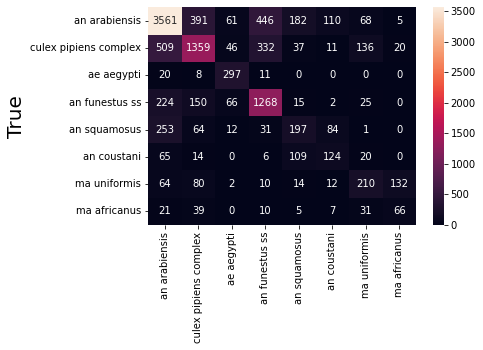

epoch = 35batch = 0 of 283duraation = 0.053058751424153644
epoch = 35batch = 100 of 283duraation = 1.5490201274553934
epoch = 35batch = 200 of 283duraation = 3.0436881224314374
..Overrun....no improvement
Epoch: 35, Train Loss: 0.77629611, Train f1: 0.67852449, Val Loss: 0.01737455, Val f1: 0.59118627, overrun_counter 0
epoch = 36batch = 0 of 283duraation = 0.05524077812830607
epoch = 36batch = 100 of 283duraation = 1.556108287970225
epoch = 36batch = 200 of 283duraation = 3.0635484059651694
..Overrun....no improvement
Epoch: 36, Train Loss: 0.71603437, Train f1: 0.69643542, Val Loss: 0.01786810, Val f1: 0.59643912, overrun_counter 1
epoch = 37batch = 0 of 283duraation = 0.055729202429453534
epoch = 37batch = 100 of 283duraation = 1.5304805437723796
epoch = 37batch = 200 of 283duraation = 3.0235995928446453
..Overrun....no improvement
Epoch: 37, Train Loss: 0.71020778, Train f1: 0.70116080, Val Loss: 0.01654739, Val f1: 0.62143353, overrun_counter 2
epoch = 38batch = 0 of 283duraation 

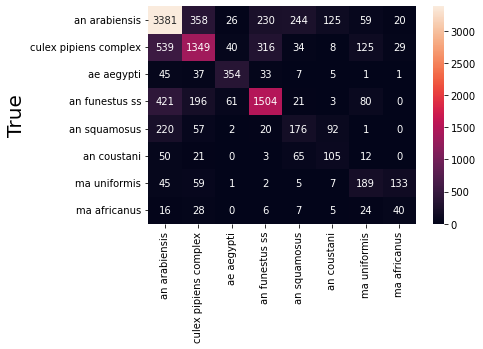

epoch = 45batch = 0 of 283duraation = 0.05688032309214274
epoch = 45batch = 100 of 283duraation = 1.5535460869471232
epoch = 45batch = 200 of 283duraation = 3.0472861488660175
..Overrun....no improvement
Epoch: 45, Train Loss: 0.68924757, Train f1: 0.71462762, Val Loss: 0.01845230, Val f1: 0.63002992, overrun_counter 0
epoch = 46batch = 0 of 283duraation = 0.05676118532816569
epoch = 46batch = 100 of 283duraation = 1.5318239370981852
epoch = 46batch = 200 of 283duraation = 3.0289171655972797
..Overrun....no improvement
Epoch: 46, Train Loss: 0.60230745, Train f1: 0.75254752, Val Loss: 0.01814464, Val f1: 0.63914121, overrun_counter 1
epoch = 47batch = 0 of 283duraation = 0.051180835564931235
epoch = 47batch = 100 of 283duraation = 1.5463716308275859
epoch = 47batch = 200 of 283duraation = 3.0325704216957092
Epoch: 47, Train Loss: 0.59497844, Train f1: 0.75593666, Val Loss: 0.01760704, Val f1: 0.64424168, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e47_

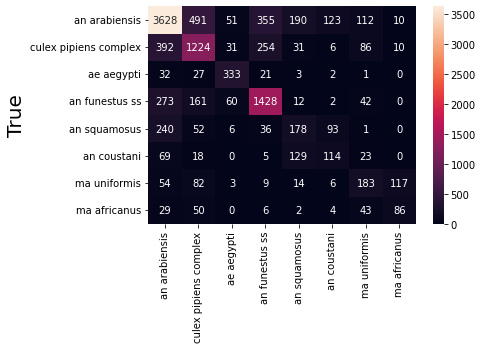

epoch = 48batch = 0 of 283duraation = 0.0623944083849589
epoch = 48batch = 100 of 283duraation = 1.570204790433248
epoch = 48batch = 200 of 283duraation = 3.035906398296356
..Overrun....no improvement
Epoch: 48, Train Loss: 0.69018368, Train f1: 0.72732894, Val Loss: 0.01960591, Val f1: 0.61659345, overrun_counter 0
epoch = 49batch = 0 of 283duraation = 0.05692110459009806
epoch = 49batch = 100 of 283duraation = 1.539188011487325
epoch = 49batch = 200 of 283duraation = 3.043101445833842
..Overrun....no improvement
Epoch: 49, Train Loss: 0.76635292, Train f1: 0.70036241, Val Loss: 0.01704035, Val f1: 0.63100845, overrun_counter 1
epoch = 50batch = 0 of 283duraation = 0.05661938985188802
epoch = 50batch = 100 of 283duraation = 1.5508539199829101
epoch = 50batch = 200 of 283duraation = 3.0341347336769102
..Overrun....no improvement
Epoch: 50, Train Loss: 0.66777090, Train f1: 0.72822722, Val Loss: 0.01992140, Val f1: 0.60748611, overrun_counter 2
epoch = 51batch = 0 of 283duraation = 0.05

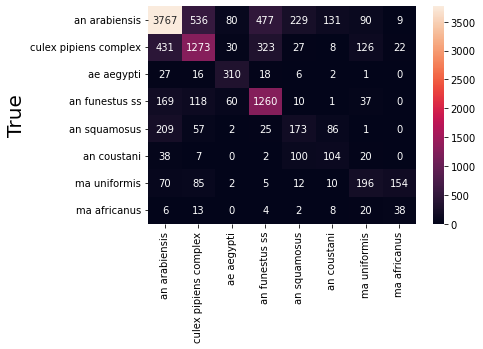

epoch = 54batch = 0 of 283duraation = 0.05726085503896077
epoch = 54batch = 100 of 283duraation = 1.590935476620992
epoch = 54batch = 200 of 283duraation = 3.0793895602226256
..Overrun....no improvement
Epoch: 54, Train Loss: 0.66656537, Train f1: 0.72364201, Val Loss: 0.02123182, Val f1: 0.61735345, overrun_counter 0
epoch = 55batch = 0 of 283duraation = 0.05439924001693726
epoch = 55batch = 100 of 283duraation = 1.5527336080869039
epoch = 55batch = 200 of 283duraation = 3.059038213888804
..Overrun....no improvement
Epoch: 55, Train Loss: 0.54377771, Train f1: 0.77606314, Val Loss: 0.01751316, Val f1: 0.63464131, overrun_counter 1
epoch = 56batch = 0 of 283duraation = 0.056990428765614824
epoch = 56batch = 100 of 283duraation = 1.5466739296913148
epoch = 56batch = 200 of 283duraation = 3.047989308834076
..Overrun....no improvement
Epoch: 56, Train Loss: 0.69750749, Train f1: 0.72136532, Val Loss: 0.01940301, Val f1: 0.64218664, overrun_counter 2
epoch = 57batch = 0 of 283duraation = 0

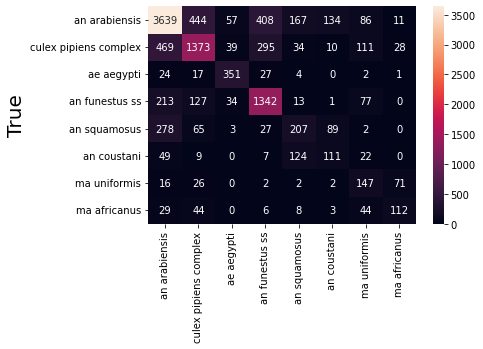

epoch = 66batch = 0 of 283duraation = 0.05275669495264689
epoch = 66batch = 100 of 283duraation = 1.5577028155326844
epoch = 66batch = 200 of 283duraation = 3.0426570534706117
..Overrun....no improvement
Epoch: 66, Train Loss: 0.64174891, Train f1: 0.74028714, Val Loss: 0.01998126, Val f1: 0.64650463, overrun_counter 0
epoch = 67batch = 0 of 283duraation = 0.05994747479756673
epoch = 67batch = 100 of 283duraation = 1.563437283039093
epoch = 67batch = 200 of 283duraation = 3.0661351641019183
..Overrun....no improvement
Epoch: 67, Train Loss: 0.59172974, Train f1: 0.75345155, Val Loss: 0.02325161, Val f1: 0.60963367, overrun_counter 1
epoch = 68batch = 0 of 283duraation = 0.05275729497273763
epoch = 68batch = 100 of 283duraation = 1.5388493855794272
epoch = 68batch = 200 of 283duraation = 3.047467573483785
..Overrun....no improvement
Epoch: 68, Train Loss: 0.70442852, Train f1: 0.72167614, Val Loss: 0.01874738, Val f1: 0.64754943, overrun_counter 2
epoch = 69batch = 0 of 283duraation = 0

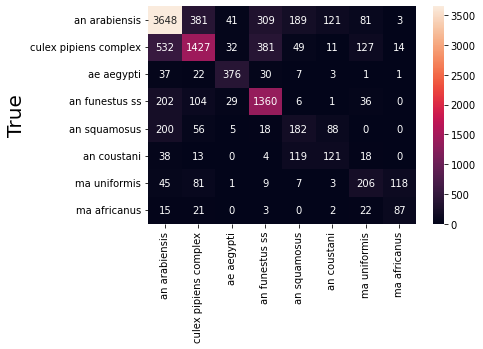

epoch = 91batch = 0 of 283duraation = 0.05509849786758423
epoch = 91batch = 100 of 283duraation = 1.5634803970654805
epoch = 91batch = 200 of 283duraation = 3.0362312038739523
..Overrun....no improvement
Epoch: 91, Train Loss: 0.59673633, Train f1: 0.75892625, Val Loss: 0.01963721, Val f1: 0.64877906, overrun_counter 0
epoch = 92batch = 0 of 283duraation = 0.0549940824508667
epoch = 92batch = 100 of 283duraation = 1.5356796662012735
epoch = 92batch = 200 of 283duraation = 3.047637391090393
..Overrun....no improvement
Epoch: 92, Train Loss: 0.64221425, Train f1: 0.74272338, Val Loss: 0.02271112, Val f1: 0.62919759, overrun_counter 1
epoch = 93batch = 0 of 283duraation = 0.055698084831237796
epoch = 93batch = 100 of 283duraation = 1.5389793515205383
epoch = 93batch = 200 of 283duraation = 3.040973722934723
..Overrun....no improvement
Epoch: 93, Train Loss: 0.58105637, Train f1: 0.76410192, Val Loss: 0.02201109, Val f1: 0.64279704, overrun_counter 2
epoch = 94batch = 0 of 283duraation = 0

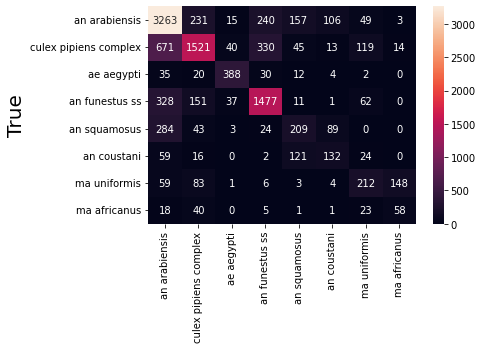

epoch = 110batch = 0 of 283duraation = 0.05526833931605021
epoch = 110batch = 100 of 283duraation = 1.573849888642629
epoch = 110batch = 200 of 283duraation = 3.073256421089172
..Overrun....no improvement
Epoch: 110, Train Loss: 0.55581859, Train f1: 0.77818155, Val Loss: 0.02205361, Val f1: 0.64939710, overrun_counter 0
epoch = 111batch = 0 of 283duraation = 0.057784608999888104
epoch = 111batch = 100 of 283duraation = 1.5468867858250936
epoch = 111batch = 200 of 283duraation = 3.065062383810679
..Overrun....no improvement
Epoch: 111, Train Loss: 0.53909418, Train f1: 0.77569717, Val Loss: 0.02059455, Val f1: 0.65268167, overrun_counter 1
epoch = 112batch = 0 of 283duraation = 0.05523406267166138
epoch = 112batch = 100 of 283duraation = 1.5697479923566182
epoch = 112batch = 200 of 283duraation = 3.072261190414429
Epoch: 112, Train Loss: 0.58353584, Train f1: 0.76306691, Val Loss: 0.01901048, Val f1: 0.66811020, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/mo

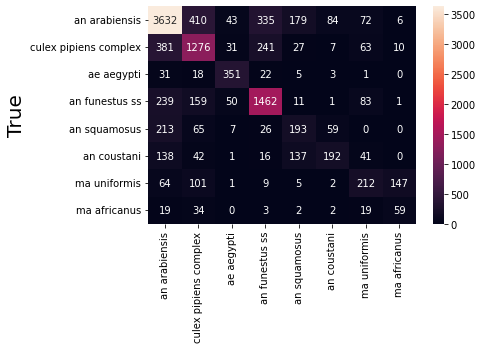

epoch = 113batch = 0 of 283duraation = 0.05866311391194661
epoch = 113batch = 100 of 283duraation = 1.5802111188570658
epoch = 113batch = 200 of 283duraation = 3.0734553813934324
..Overrun....no improvement
Epoch: 113, Train Loss: 0.63160776, Train f1: 0.75411251, Val Loss: 0.02055135, Val f1: 0.65199498, overrun_counter 0
epoch = 114batch = 0 of 283duraation = 0.05762691497802734
epoch = 114batch = 100 of 283duraation = 1.5441897551218668
epoch = 114batch = 200 of 283duraation = 3.0449055194854737
..Overrun....no improvement
Epoch: 114, Train Loss: 0.58292454, Train f1: 0.77042910, Val Loss: 0.02087143, Val f1: 0.65769863, overrun_counter 1
epoch = 115batch = 0 of 283duraation = 0.05532719691594442
epoch = 115batch = 100 of 283duraation = 1.584595763683319
epoch = 115batch = 200 of 283duraation = 3.069669572512309
..Overrun....no improvement
Epoch: 115, Train Loss: 0.57686747, Train f1: 0.76299082, Val Loss: 0.02007532, Val f1: 0.66082324, overrun_counter 2
epoch = 116batch = 0 of 283

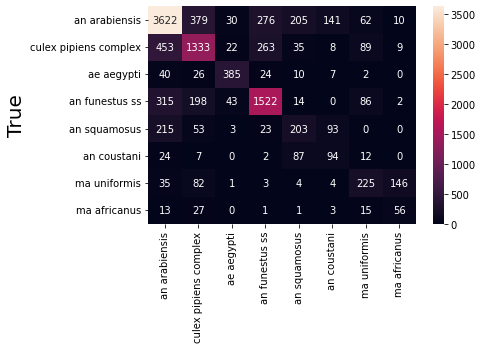

epoch = 119batch = 0 of 283duraation = 0.05596291224161784
epoch = 119batch = 100 of 283duraation = 1.548144284884135
epoch = 119batch = 200 of 283duraation = 3.058254273732503
..Overrun....no improvement
Epoch: 119, Train Loss: 0.54877120, Train f1: 0.77652536, Val Loss: 0.02074370, Val f1: 0.66587845, overrun_counter 0
epoch = 120batch = 0 of 283duraation = 0.058711389700571694
epoch = 120batch = 100 of 283duraation = 1.5744028647740682
epoch = 120batch = 200 of 283duraation = 3.090457320213318
..Overrun....no improvement
Epoch: 120, Train Loss: 0.53011602, Train f1: 0.79218629, Val Loss: 0.02137281, Val f1: 0.66048169, overrun_counter 1
epoch = 121batch = 0 of 283duraation = 0.05458387533823649
epoch = 121batch = 100 of 283duraation = 1.5667540828386943
epoch = 121batch = 200 of 283duraation = 3.0612789034843444
Epoch: 121, Train Loss: 0.46889683, Train f1: 0.80941823, Val Loss: 0.01987973, Val f1: 0.67007353, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/m

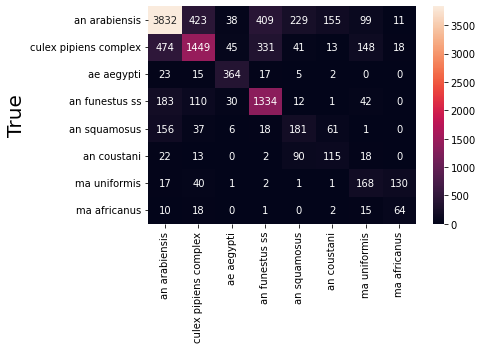

epoch = 122batch = 0 of 283duraation = 0.0567121426264445
epoch = 122batch = 100 of 283duraation = 1.5650703668594361
epoch = 122batch = 200 of 283duraation = 3.083324654897054
..Overrun....no improvement
Epoch: 122, Train Loss: 0.64887268, Train f1: 0.74927385, Val Loss: 0.02061632, Val f1: 0.66424672, overrun_counter 0
epoch = 123batch = 0 of 283duraation = 0.057708863417307535
epoch = 123batch = 100 of 283duraation = 1.5528027057647704
epoch = 123batch = 200 of 283duraation = 3.0579661687215167
..Overrun....no improvement
Epoch: 123, Train Loss: 0.55390105, Train f1: 0.78414533, Val Loss: 0.02075816, Val f1: 0.66916898, overrun_counter 1
epoch = 124batch = 0 of 283duraation = 0.05548337697982788
epoch = 124batch = 100 of 283duraation = 1.5483541011810302
epoch = 124batch = 200 of 283duraation = 3.048626220226288
..Overrun....no improvement
Epoch: 124, Train Loss: 0.60999554, Train f1: 0.75277098, Val Loss: 0.02083163, Val f1: 0.66452737, overrun_counter 2
epoch = 125batch = 0 of 283

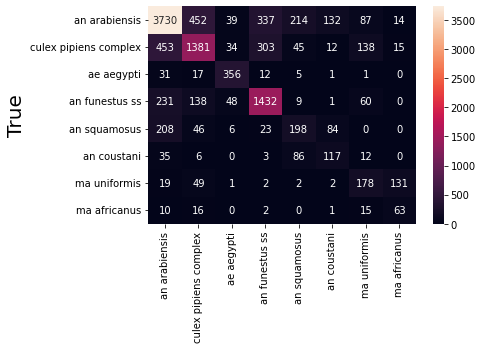

epoch = 132batch = 0 of 283duraation = 0.05477853616078695
epoch = 132batch = 100 of 283duraation = 1.5611494700113933
epoch = 132batch = 200 of 283duraation = 3.095430338382721
..Overrun....no improvement
Epoch: 132, Train Loss: 0.60548212, Train f1: 0.75048447, Val Loss: 0.02180122, Val f1: 0.65857293, overrun_counter 0
epoch = 133batch = 0 of 283duraation = 0.05767608086268107
epoch = 133batch = 100 of 283duraation = 1.5721593221028647
epoch = 133batch = 200 of 283duraation = 3.084541396299998
..Overrun....no improvement
Epoch: 133, Train Loss: 0.56498128, Train f1: 0.77717574, Val Loss: 0.02040152, Val f1: 0.67062879, overrun_counter 1
epoch = 134batch = 0 of 283duraation = 0.059393699963887533
epoch = 134batch = 100 of 283duraation = 1.5641371806462605
epoch = 134batch = 200 of 283duraation = 3.0791819016138713
..Overrun....no improvement
Epoch: 134, Train Loss: 0.50585244, Train f1: 0.79670985, Val Loss: 0.02197283, Val f1: 0.65567251, overrun_counter 2
epoch = 135batch = 0 of 28

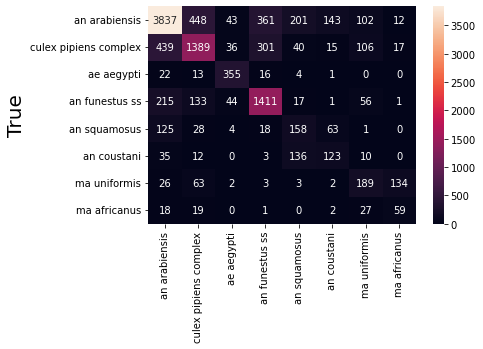

epoch = 141batch = 0 of 283duraation = 0.053579552968343096
epoch = 141batch = 100 of 283duraation = 1.562861716747284
epoch = 141batch = 200 of 283duraation = 3.073325002193451
..Overrun....no improvement
Epoch: 141, Train Loss: 0.54393293, Train f1: 0.77820933, Val Loss: 0.02095851, Val f1: 0.66221911, overrun_counter 0
epoch = 142batch = 0 of 283duraation = 0.05643049081166585
epoch = 142batch = 100 of 283duraation = 1.5568683584531149
epoch = 142batch = 200 of 283duraation = 3.0480220635732014
..Overrun....no improvement
Epoch: 142, Train Loss: 0.62092780, Train f1: 0.76857021, Val Loss: 0.02099541, Val f1: 0.66277269, overrun_counter 1
epoch = 143batch = 0 of 283duraation = 0.05682717561721802
epoch = 143batch = 100 of 283duraation = 1.5709179639816284
epoch = 143batch = 200 of 283duraation = 3.0522987882296246
..Overrun....no improvement
Epoch: 143, Train Loss: 0.61507596, Train f1: 0.75318377, Val Loss: 0.02178455, Val f1: 0.65704760, overrun_counter 2
epoch = 144batch = 0 of 28

KeyboardInterrupt: 

In [20]:
model =MyModel()




#train_loader, val_loader,test_loader, model ,class_weights, classes = classes, num_epochs = args.num_epochs ,n_channels = 1
#train_loader, val_loader,test_loader, model, classes ,df,num_epochs = args.num_epochs ,n_channels = 1
tr_model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model,classes,class_weights ,num_epochs = num_epochs )

print("ALL DONE!!!!")


In [ ]:
def load_model(filepath, model=MyModel('convnext_xlarge_in22k')):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model